In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxa
from scipy import stats
from pyproj import Transformer

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]

data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv_5.pkl'), 'rb') as f:
    cor_vv = pickle.load(f)

In [2]:
def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

In [3]:
def get_times(band):
    f1t = [fps for fps in image_fps if (fps['pol'] == 'VV') & (band in fps['fp'])][0]['flight1'].astimezone('US/Mountain')
    f2t = [fps for fps in image_fps if (fps['pol'] == 'VV') & (band in fps['fp'])][0]['flight2'].astimezone('US/Mountain')
    return f1t, f2t
def get_string_from_dt(dt):
    start = pd.to_datetime(dt).strftime('%Y_%m_%d')
    h = int(pd.to_datetime(dt).strftime('%H'))
    if h%3 != 0:
        h = h-h%3
    if h <10:
        return f'{start}_0{h}'
    else:
        return f'{start}_{h}'

In [4]:
model_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/modeling/swed'
model_fps = glob(join(model_dir, '*.flt'))
hdr_fps = glob(join(model_dir, '*.hdr'))

In [5]:
smelts = []
cors = []
incs = []
trees = []
for band in cor_vv['Grand_Mesa,_CO'].band.values:
    fts = get_times(band)
    da = cor_vv['Grand_Mesa,_CO'].sel({'band':band})
    direction = band.split('_')[1][:3]
    inc_name = f'{direction}-inc'
    if fts[0].year == 2020:
        res = []
        for ft in fts:
            dt_str = get_string_from_dt(ft)
            smelt = rxa.open_rasterio([fp for fp in model_fps if dt_str in fp][0])
            smelt = smelt.rio.set_crs('EPSG:32612')
            re = smelt.rio.reproject_match(da)
            re = re.where(re >= 0)
            res.append(re)
        comb = res[0] + res[1]
        ms = comb.values.ravel()
        ins = da[inc_name].values.ravel()
        ts = da['tree-perc'].values.ravel()
        cos = da['cor_vv'].values.ravel()

        ms, ins, ts, cos = clean_nps([ms, ins, ts, cos])
        smelts.append(ms)
        cors.append(cos)
        incs.append(ins)
        trees.append(ts)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
incs = np.concatenate(incs)
melt = np.concatenate(smelts)
incs = np.rad2deg(incs)

slope: -0.33654854411796725. intercept: 0.8427490471264848. r_value -0.23327640860016183. p value: 0.0


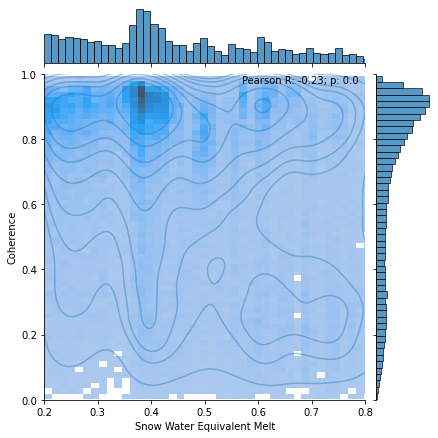

In [37]:
cond = (trees < 5) & (incs < 50) & (incs > 40) & (melt > 0.2)

slope, intercept,r,p, _, _ = r2_value(melt[cond], cors[cond])

plt.Figure(figsize = (12,8))
n = 1
g = sns.jointplot(x = melt[cond][::n], y = cors[cond][::n], kind = 'hist', bins = 60, ylim = (0,1), xlim = (0.2, 0.8))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [.57,0.97])
g.ax_joint.set_xlabel('Snow Water Equivalent Melt')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/snowmelt', 'snowmelt_all.png'))